# Time Series with Prophet
In this notebook, I am exploring prophet for time series analysis. Data was retrieved from Kaggle. Details relating to features are provided in the notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import basic packages
import numpy as np
import pandas as pd
from pandas import datetime

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [2]:
train = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date')
store = pd.read_csv('store.csv')
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

### Exploratory Analysis

In [3]:
print("DataFrame Shape: ", train.shape)
train.head()

DataFrame Shape:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1



**Short description:**
* Sales: the turnover for any given day (target variable).
* Customers: the number of customers on a given day.
* Open: an indicator for whether the store was open: 0 = closed, 1 = open.
* Promo: indicates whether a store is running a promo on that day.
* StateHoliday: indicates a state holiday. Normally all stores, with few * exceptions, are closed on state holidays.
* SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.


In [4]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
# Data Extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# Adding new variable
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].describe()


count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

**Note:** 
The new 'SalesPerCustomer' variable, we calculate, on average, how much customers spend at each store. From the summary table alone, we can see that across all stores, customers on average spend €9.49, with a 75% of customers spending €10.90 or less. This means that the majority of customers visiting Rossmann Stores spend less than €11, with few people making large purchases. We can also see that there are days when stores make €0.00. </p>

Let's visualise this using a boxplot.

Text(0.5,1,'Spend per Customer')

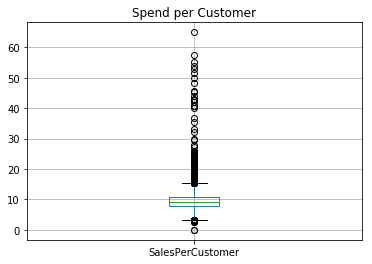

In [6]:
# Boxplot
train.boxplot(['SalesPerCustomer'])
plt.title('Spend per Customer')

Text(0.5,1,'Sales Distribution')

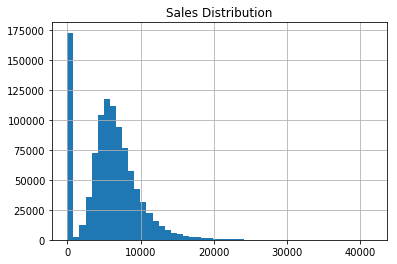

In [7]:
# Let's also check out the distribution
train['Sales'].hist(bins = 50, )
plt.title('Sales Distribution')

**Note: **Here, we see a near normal distribution with a significant number of sales/customer with €0.00.  Let's have a look what's going on here. Perhaps it's due to store closure?

### Missing Values and Store Closures

#### Closed stores and Zero Sales

In [8]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [9]:
print("Number of stores that are closed and with zero sales: {}".format(len(train[(train.Open == 0) & (train.Sales == 0)])))

Number of stores that are closed and with zero sales: 172817


**Note:** There are about 172817 closed stores with zero sales in the data. This is approximately 10% of the entire dataset. Let's remove these so they dont unnecessarily bias the data.

In [10]:
# open stores with zero sales
zero_sales = train[(train.Open !=0) & (train.Sales == 0)]
print("Open Stores with €0.00 sales: {}".format(zero_sales.shape[0]))
zero_sales.head()

Open Stores with €0.00 sales: 54


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


**Note:** Interestingly, there are stores that are open but with €0.00 sales. One possible explanation for this may be store renovation, or other external factors.

In [11]:
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]
print("Final dataframe shape: {}".format(train.shape))

Final dataframe shape: (844338, 13)


### Store Dataframe

In [12]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
store['CompetitionOpenSinceYear'].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

In [14]:
train.Year.unique()

array([2015, 2014, 2013])

In [15]:
store.shape

(1115, 10)

**Column Descriptions: **
* Store: a unique Id for each store
* StoreType: differentiates between 4 different store models: a, b, c, d
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [16]:
# Checking for missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

**Note:** There are quite a few variables with missing data. Let's start with CompetitionDistance.

In [17]:
# Null values Competition Distance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


**Note: **Cross checking these stores with the train table, it seems all three of these stores are active stores, and have regular sales. It would suggest then that the NaNs in this table are missing values. So let's fill these with the median value.

In [18]:
# Fill NaN
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [19]:
# store[pd.isnull(store.Promo2SinceWeek)]

In [20]:
# # no promo/information
# _ = store[pd.isnull(store.Promo2SinceWeek)]
# _[_.Promo2 == 0]

**Note:** For the remainder of the missing values, we simply have no information on these. There are a number of ways in which we can deal with missing data. The most aggressive way would be remove these observations. However, we would be losing a lot of information this way. </p>

Another way to deal with missing values would be filling with '0'. But given that the missing values in the columns are year/month values, this would not be ideal either. </p>

So instead, let's try to fill with median values.


In [21]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [22]:
store['CompetitionOpenSinceMonth'].fillna(7, inplace=True) # fill missing data with July (middle of year)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(), inplace=True)

In [23]:
# Joining the store and train datasets
train_store = pd.merge(train, store, how='inner', on = 'Store')
print("train_store shape: {}".format(train_store.shape))
train_store.head()

train_store shape: (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### Now, let's look at the how the store types affect sales

In [24]:
train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [25]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


**Note:** From this summary table, we can see that StoreType b has the highest mean sales with 75% of StoreType b stores having sales figures above €10000. This is much higher than the sales figures for StoreTypes a, c, and d. But also note that we have much fewer observations for StoreType b. 

In [26]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum().sort_values('Sales', ascending=False)

,Customers,Sales
StoreType,,
a,363541431,3165334859
d,156904995,1765392943
c,92129705,783221426
b,31465616,159231395


**Note:** But when we look at total sales for each of the StoreTypes, however, we can see that StoreType b has the lowest total sales, with StoreType A having total sales almost 20x that of StoreType B.

### Next, let's visualise the sales trends by Month and by Day of Week

/Users/cherylto/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


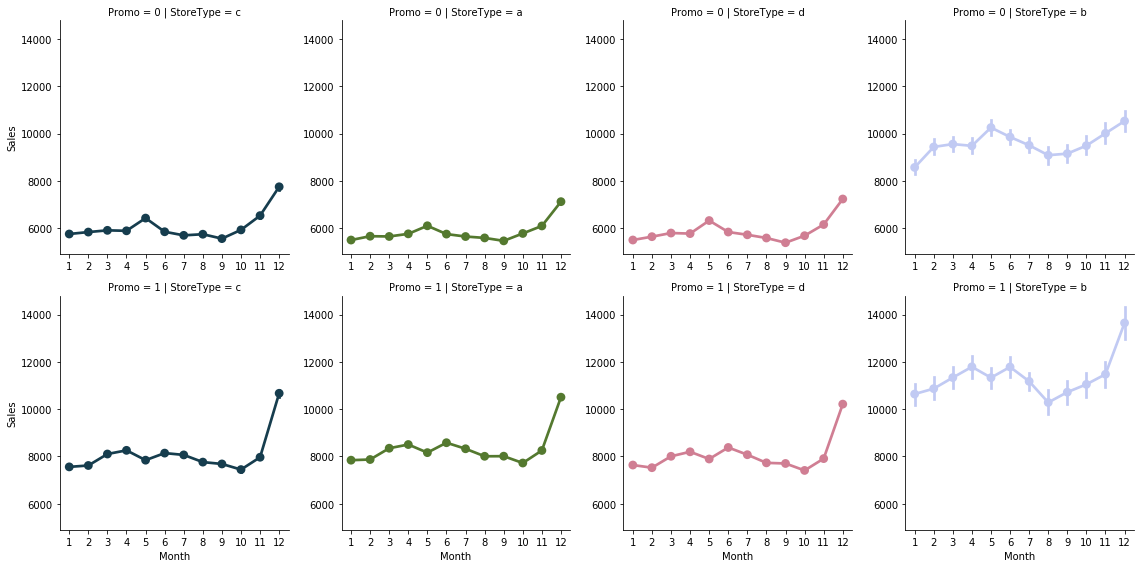

In [27]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = "cubehelix",
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               ) 

**Note: ** From this graph, we can see that sales are higher when stores are running promotions.

/Users/cherylto/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


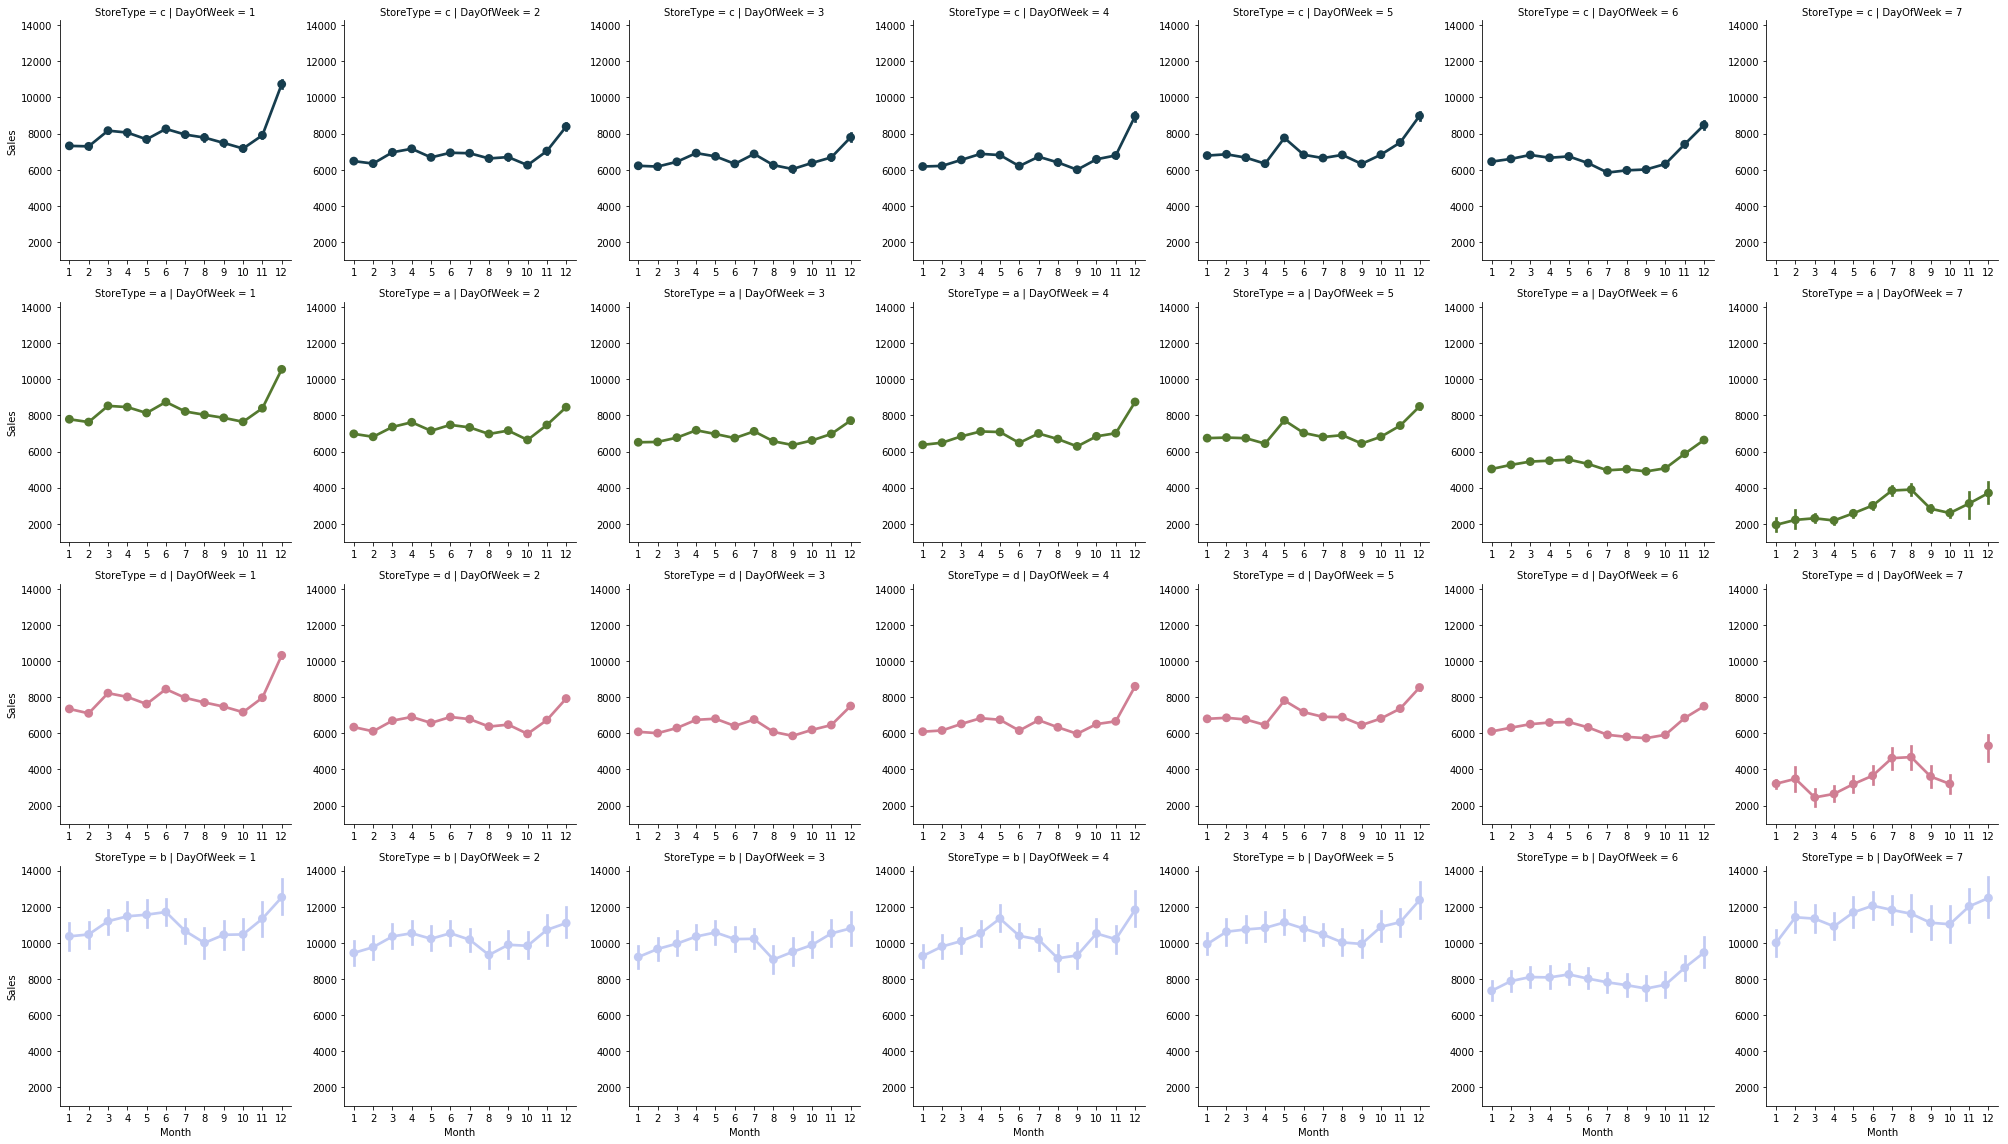

In [28]:
# customers
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = "cubehelix",
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               ) 

**Note: ** There are lots of interesting information on this plot. Full explanation is beyond the remit of this notebook. Just a few trends quickly though:
* StoreType C appears to be closed on Sundays
* Storetype D seem to have closed their doors on Sundays in November
* For StoreTypes A and D, sales are lowest on Sundays, whereas for StoreType B, sales are lowest on Saturdays

### To finish off our exploratory analysis, let's have a look at promo variables

In [29]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12* (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo Open time 
train_store['PromoOpen'] = 12*(train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4



In [30]:
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,23.514536,56.507971
b,10233.380141,2022.211825,12.880372,59.228085
c,6933.126425,815.538073,28.064913,57.783691
d,6822.300064,606.353935,26.038356,51.948850


**Note:** Here, we see that while StoreType b have had competetions for the period of time, they had the fewest months in which promotions were ran. This is in contrast to StoreType d where for half the time that this type of store has been open it has been running promotions. </p>

Considering this new information with our factorplots, even though StoreType d had the longest running promotions, it actually performs on par with StoreTypes c and c.

### Correlation Analysis

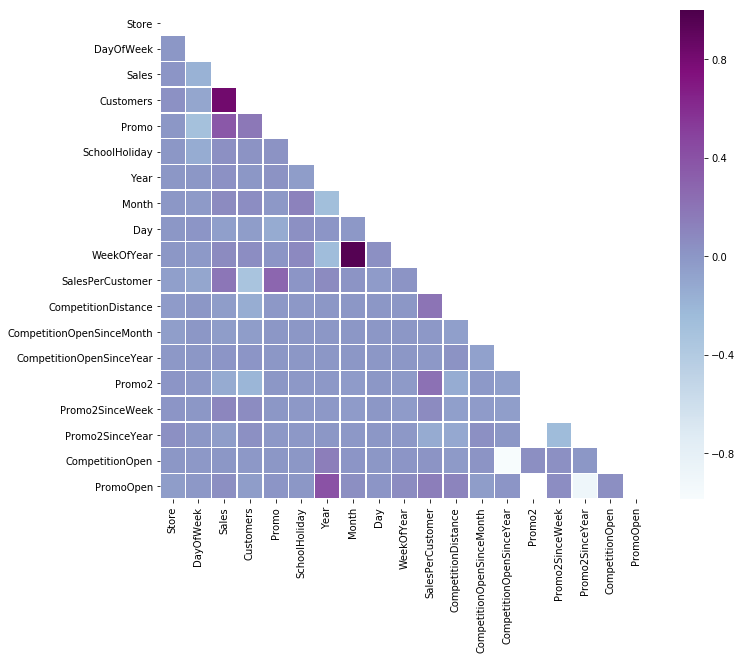

In [31]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

**Note:** At a quick glance, some features seem to be correlated with each other
* sales, promo
* sales, customer
* SalesPerCustomer, Sales
* SalesPerCustomer, Promo2
* CompetitionDistance, SalesPercustomer

Clearly promotions have a lot to do with sales!!! Let's explore this some more.

In [32]:
# group by StoreType, Promo, Promo2
pd.DataFrame(train_store.groupby(['StoreType','Promo', 'Promo2'])['Sales'].mean())

Sales
StoreType Promo Promo2              
a         0     0        6102.371493
                1        5473.860548
          1     0        8538.298356
                1        8035.806221
b         0     0       10511.458662
                1        7240.801153
          1     0       12165.463888
                1        9209.755685
c         0     0        6728.066370
                1        5324.450380
          1     0        8809.760601
                1        7265.312892
d         0     0        6154.165443
                1        5629.857267
          1     0        8395.900716
                1        7731.786972

/Users/cherylto/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


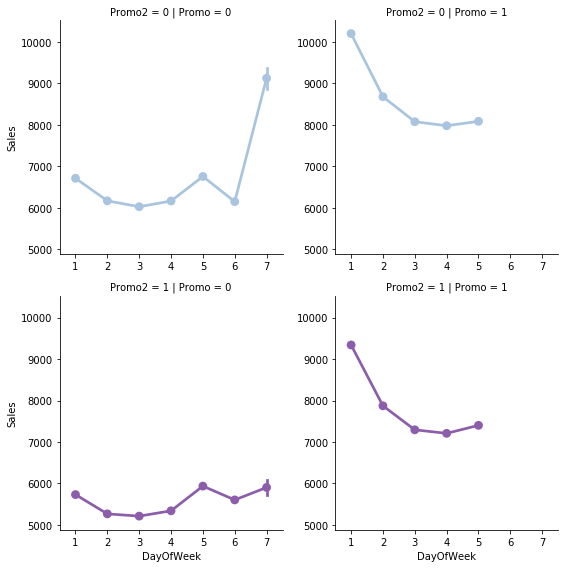

In [33]:
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = "BuPu") 

**Observations:** Running 2 promotions at the same time tends to decrease overall sales. However, running only store-wide promotion seems to boost sales. This seems to be true for all Storetypes. </p>

Another thing worth noting is that stores that run store-wide promotions appear to be closed on weekends.

## Preliminary Findings of Exploratory Data Analysis
* StoreType A is the highest grossing across the four StoreTypes drawing in the most customers
* While StoreType B has the highest sales on average, they actually bring in the least amount of revenue
* Promotions boost sales to a certain degree, but multiple campaigns can work against the company
* When there is a promotion, most of the sales happen on Monday
* When there are no promotions, Sundays have the highest sales

## Now, Let's have a look at some Time Series Data

In [34]:
train.reset_index(inplace=True)

In [35]:
TrainStore = pd.merge(train, store, how='inner', on = 'Store').set_index('Date')

In [36]:
# Outcome variable should be of dtype=float
TrainStore['Sales'] = TrainStore['Sales'] * 1.0

In [37]:
Sales_A = TrainStore[TrainStore['StoreType'] == 'a']['Sales']
Sales_B = TrainStore[TrainStore['StoreType'] == 'b']['Sales']
Sales_C = TrainStore[TrainStore['StoreType'] == 'c']['Sales']
Sales_D = TrainStore[TrainStore['StoreType'] == 'd']['Sales']

In [38]:
TrainStore.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### Weekly Trend

Text(0.5,1,'Time Series Plots by StoreType')

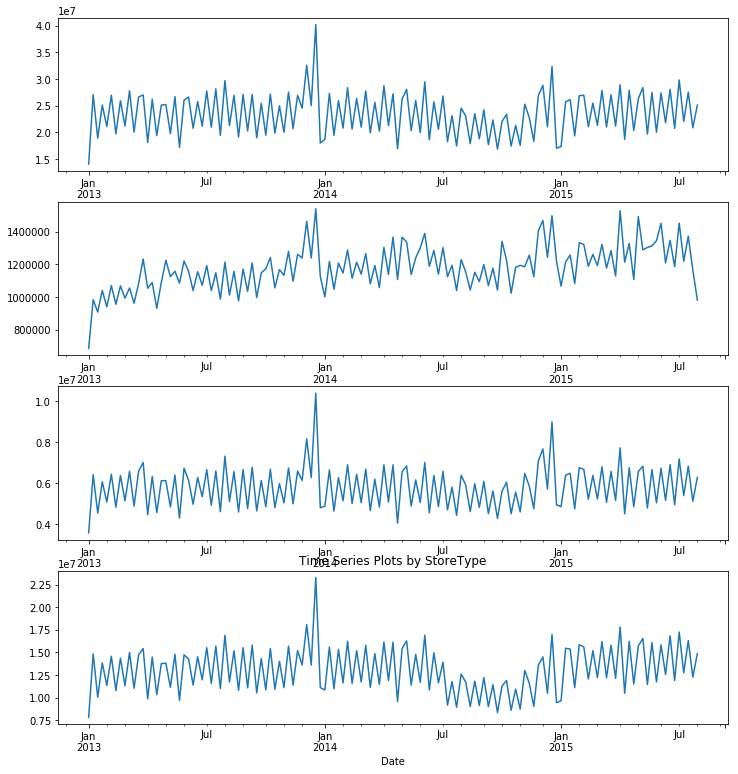

In [39]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
Sales_A.resample('W').sum().plot(ax = ax1)
Sales_B.resample('W').sum().plot(ax = ax2)
Sales_C.resample('W').sum().plot(ax = ax3)
Sales_D.resample('W').sum().plot(ax = ax4)
plt.title('Time Series Plots by StoreType')

**Observations: ** Across all four storetypes, sales peak at over the Christmas season. Christmas sales were stronger in 2014 than 2015. </p>

For StoreType b, there is a slight dip in the new year in 2015, however, sales quickly picked up and return and may even have surpassed Christmas sales between April and May. Sales decreased slightly thereafter, but remains strong.

### Monthly Trend

Text(0.5,1,'Time Series Plots by StoreType')

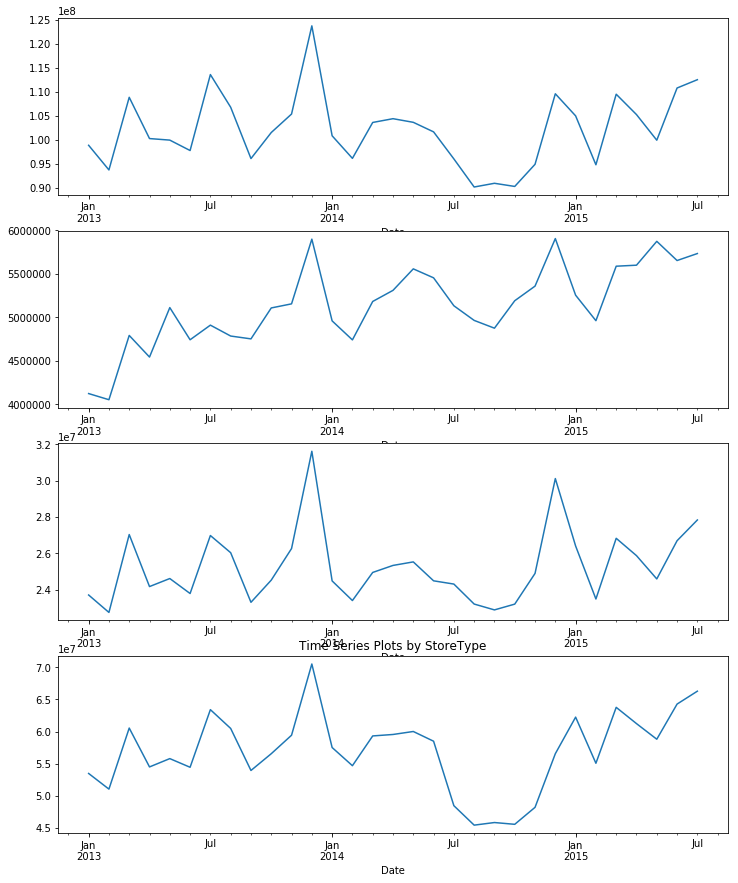

In [40]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 15))
Sales_A.resample('M').sum().plot(ax = ax1)
Sales_B.resample('M').sum().plot(ax = ax2)
Sales_C.resample('M').sum().plot(ax = ax3)
Sales_D.resample('M').sum().plot(ax = ax4)
plt.title('Time Series Plots by StoreType')

**Observation: ** By resampling to month intervals, we can see that sales trends for StoreTypes A and B, albeit with differetn sals volumns, are more similar to each other than StoreTypes C and D.

## Time Series Forecasting with Prophet
Prophet is a TimeSeries forecasting tool developed by the team at Facebook. It enables performing [automated forecasting](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) which are already implemented in R at scale in Python 3.

In [41]:
# # importing data
df = pd.read_csv("train.csv")

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 7 (StoreType A)
sales = df[df.Store == 7].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [42]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014986,2013-01-02,8244
1013871,2013-01-03,7231
1012756,2013-01-04,7758
1011641,2013-01-05,5218
1009411,2013-01-07,12718


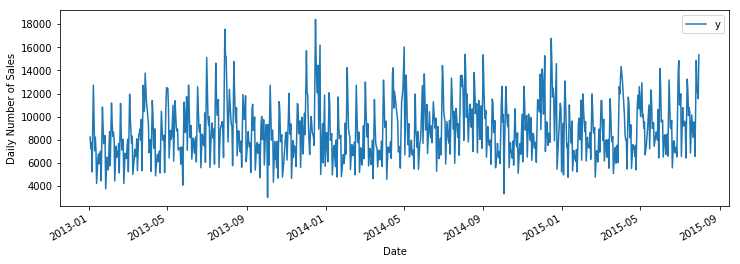

In [43]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [44]:
# create holidays dataframe
state_dates = train[(train.StateHoliday == 'a') | (train.StateHoliday == 'b') | (train.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = train[train.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,ds,holiday
0,2015-06-04,state_holiday
1,2015-06-04,state_holiday
2,2015-06-04,state_holiday
3,2015-06-04,state_holiday
4,2015-06-04,state_holiday


In [45]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
model.fit(sales)

# dataframe that extends into future 6 weeks 
FutureDates = model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
FutureDates.tail(7)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
821,2015-09-05
822,2015-09-06
823,2015-09-07
824,2015-09-08
825,2015-09-09
826,2015-09-10
827,2015-09-11


In [46]:
# predictions
forecast = model.predict(FutureDates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
821,2015-09-05,6049.073248,2940.998858,9371.138470
822,2015-09-06,8548.495336,5355.893498,11800.962891
823,2015-09-07,10264.298540,6777.011530,13482.676849
824,2015-09-08,9253.135823,6042.152791,12704.065982
825,2015-09-09,7903.638927,4367.809772,11202.851551
826,2015-09-10,7990.945673,4476.828157,11313.239997
827,2015-09-11,8733.865237,5593.214493,12047.087429


In [47]:
fc = forecast[['ds', 'yhat']]

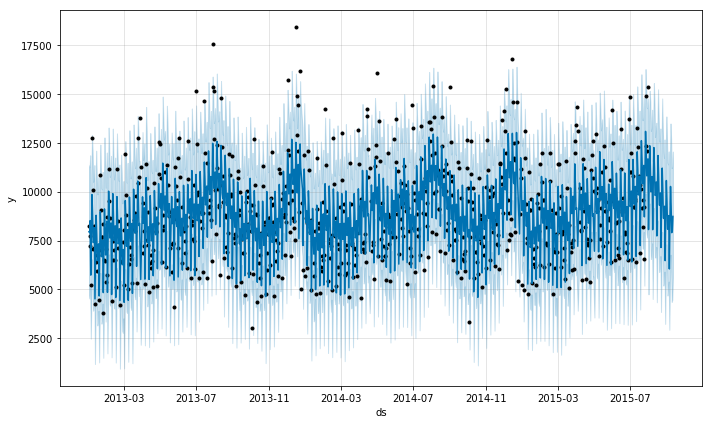

In [ ]:
# visualizing predicions
model.plot(forecast);

**Note: **Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

In [ ]:
model.plot_components(forecast);

**Discussion: **The four plots show overall yearly, yearly, weekly, and holiday trends. The first plot shows that for store 7, there is an upward trend year on year. The second plot shows the holiday gaps included in the model. The third plot shows the yearly trend. Specifically, we see that there are two peak season for sales. The first between July and September, the second over Christmas. The final plot is a weekday trend showing that most of the sales happen on Monday, then slowly decreasing through the week.
